In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Spam Detection 

In [3]:
from IPython.display import display
import numpy as np
import pandas as pd
import string
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB # good for classic binary features
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer
import nltk



nltk.download('punkt')

C:\Users\woill\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\woill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Preprocessing

In [4]:
df = pd.read_csv("./data/spam.csv", encoding = "ISO-8859-1", engine='python')

In [5]:
df.head()

,Unnamed: 0,label,SMS
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Cleaning

Hare we will do a few things : <br/>
    1. Check for missing values
    2. Remove the first column
    3. Create a binary label column
    4. Remove (but save) punctuation from the SMS

In [6]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [7]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
df.label.unique() #checking for eventual case problems before mapping

array(['ham', 'spam'], dtype=object)

In [9]:
df['target'] = df.label.map({'ham':0, 'spam':1})

In [10]:
for punctu in string.punctuation:
    df[punctu] = df['SMS'].map(lambda v : v.count(punctu))

In [11]:
cleaned = []
for i in range(len(df['SMS'])):
    clean = df['SMS'][i].translate(str.maketrans('', '', string.punctuation))
    clean = clean.lower()
    cleaned.append(clean)
df.insert(loc=0, column="cleaned_SMS", value=cleaned)
df.head()

,cleaned_SMS,label,SMS,target,!,"""",#,$,%,&,...,[,\,],^,_,`,{,|,},~
0,go until jurong point crazy available only in ...,ham,"Go until jurong point, crazy.. Available only ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ok lar joking wif u oni,ham,Ok lar... Joking wif u oni...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,free entry in 2 a wkly comp to win fa cup fina...,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,u dun say so early hor u c already then say,ham,U dun say so early hor... U c already then say...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,nah i dont think he goes to usf he lives aroun...,ham,"Nah I don't think he goes to usf, he lives aro...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have the cleaned SMS text, and we saved the number of each punctuation, just in case we might like to add it, as an input to our model later on. It's not crazy to think that SMS Spams are maybe more full of punctuation, with messages like :<br/>
>'You won somehting !!!!! Come get it here : www.somerandomwebsite.com//givemeyourcreditcard//trustmeimyourfriend !!'

In [12]:
df['word_count'] = df['cleaned_SMS'].apply(lambda v : len(v.split(" ")))

### Quick data analysis

Here we will look at the data distribution on things such as :
    1. Word Count
    2. Punctuation

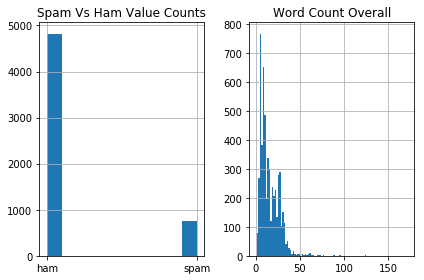

In [13]:
ax1 = plt.subplot(121)
df.label.hist(density = False) 
plt.title('Spam Vs Ham Value Counts')

ax2 = plt.subplot(122)
df['word_count'].hist(bins=100)
plt.title('Word Count Overall')

plt.tight_layout()
plt.show()
# Clear class imbalance, keep in mind when looking at performances
# Text messages, so not that big a text => simple Bag of Word approach might suffice, we'll see if we need more compex approach such as word embedding, n-gram

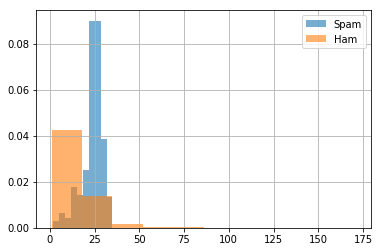

In [14]:
df[df.label == 'spam']['word_count'].hist(alpha = 0.6, density = True, label = 'Spam')
df[df.label == 'ham']['word_count'].hist(alpha = 0.6, density = True, label = 'Ham')
plt.legend()
# Spams are usually longer than regular texts messages

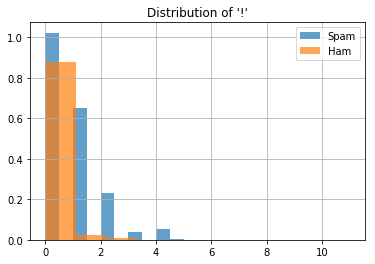

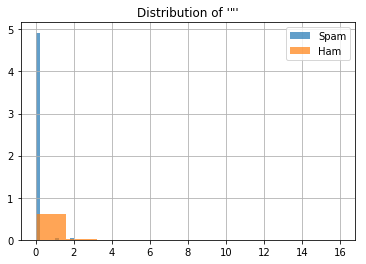

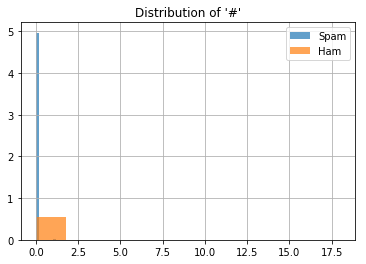

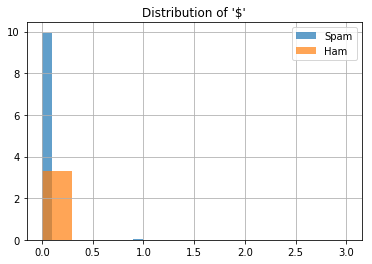

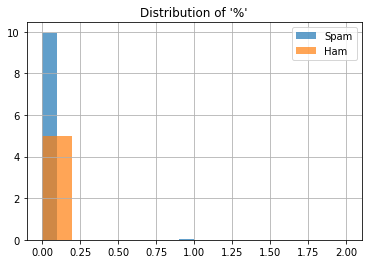

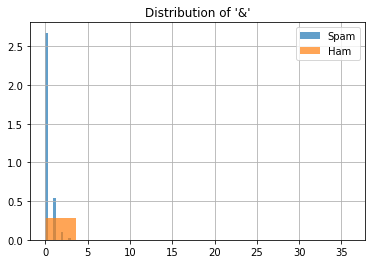

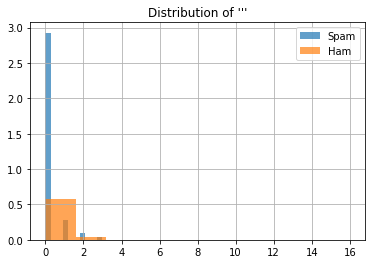

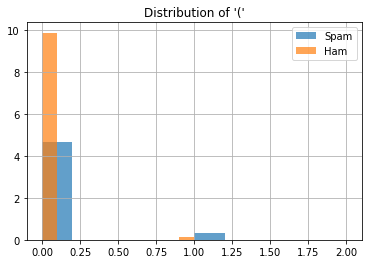

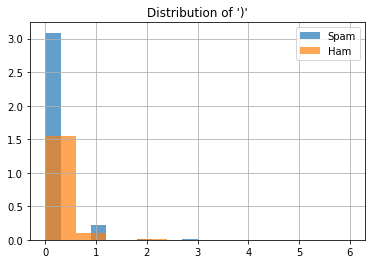

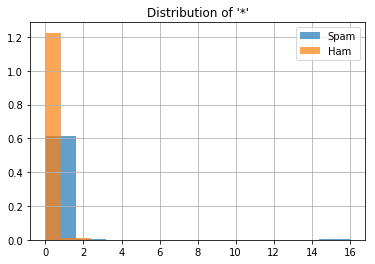

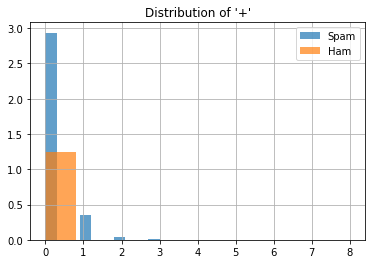

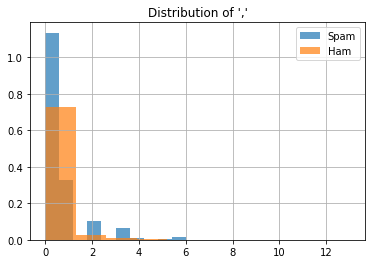

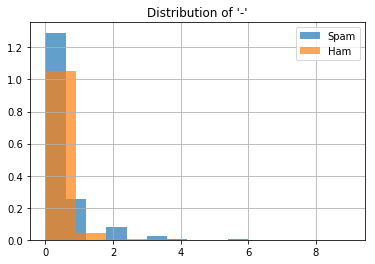

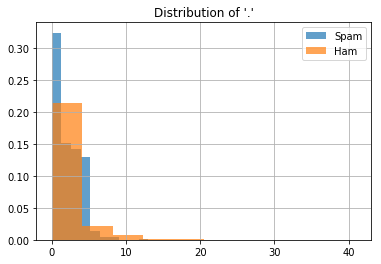

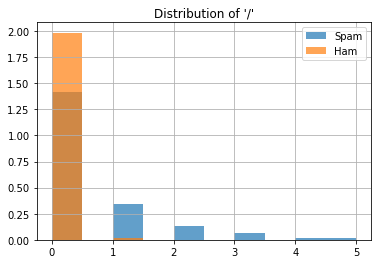

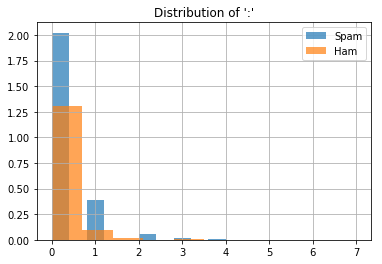

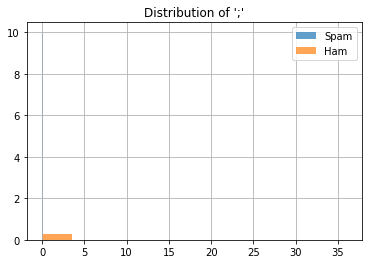

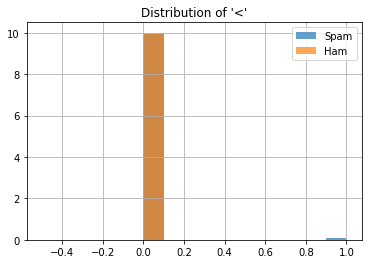

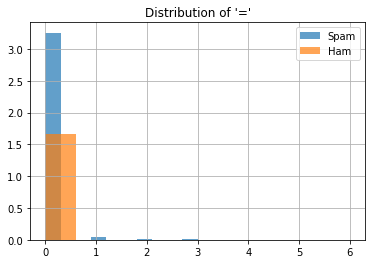

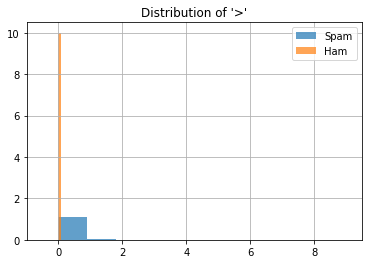

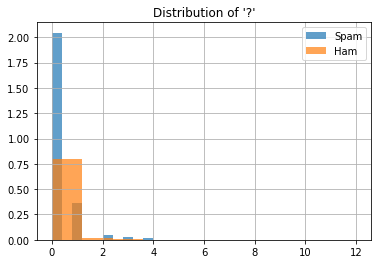

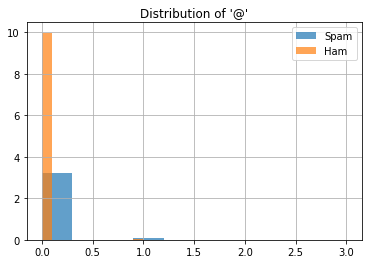

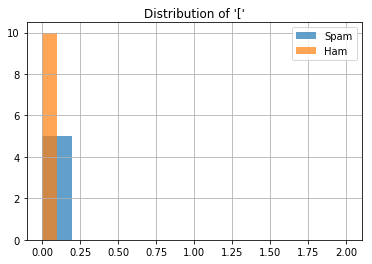

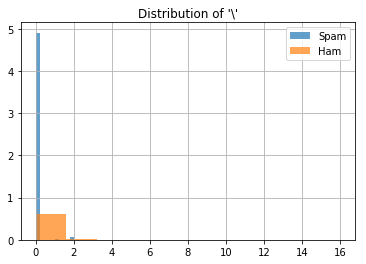

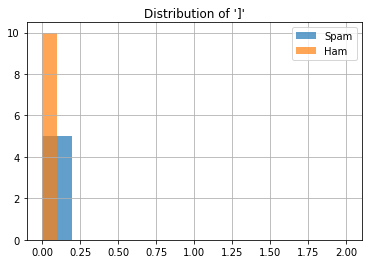

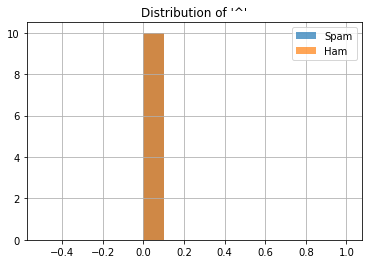

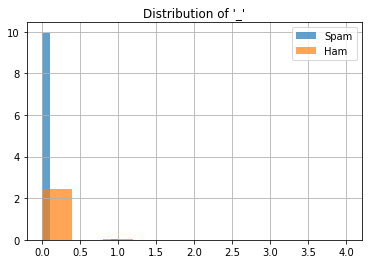

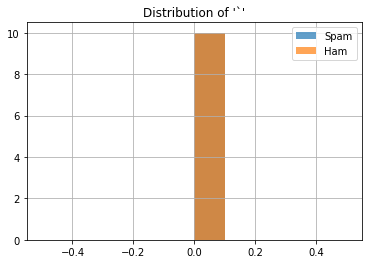

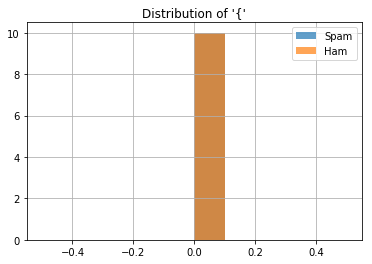

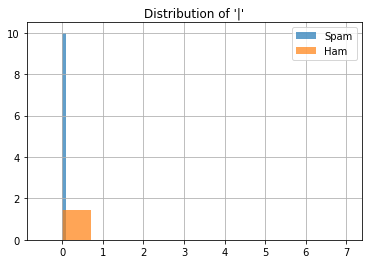

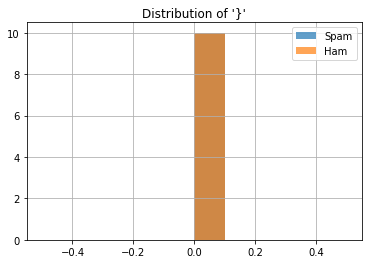

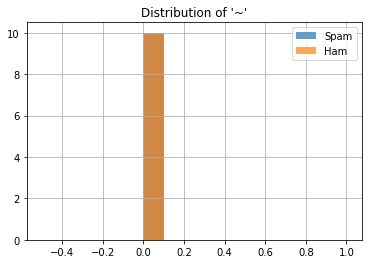

In [15]:
for punctu in string.punctuation:
    df[df.label == 'spam'][punctu].hist(alpha = 0.7, density = True, label = 'Spam')
    df[df.label == 'ham'][punctu].hist(alpha = 0.7, density = True, label = 'Ham')
    plt.legend()
    plt.title("Distribution of '" + punctu + "'")
    plt.show()
# It seems that "classical" punctuation like . , ? are not good indicator of something beeing a spam or not
# But more "unorthodox" punctuation like / @ ] seem to give more information on the label

#### More Features

I am going to try with the findings of this paper : https://www.researchgate.net/publication/318657353_Towards_Filtering_of_SMS_Spam_Messages_Using_Machine_Learning_Based_Technique

• Presence of Mathematical Symbols<br/>
• Presence of URLs<br/>
• Presence of Dots<br/>
• Presence of special symbols<br/>
• Presence of emotions<br/>
• Lowercased words<br/>
• Uppercased words<br/>
• Presences of Mobile Number<br/>
• Keyword specific<br/>
• Message Length (we already have this one)<br/>

In [16]:
Mathematical_Symbols = ['+','−','<','>','/','^','*']
df["S1"] = df.SMS.apply(lambda v : max([min(v.count(k),1) for k in Mathematical_Symbols]))

In [17]:
import re
WEB_URL_REGEX = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
df["S2"] = df.SMS.apply(lambda v : min(len(re.findall(WEB_URL_REGEX,v)),1) )

In [18]:
df["S3"] = df.SMS.apply(lambda v : max([min(v.count('.'),1)]))

In [19]:
Special_Symbols = ['!','*','&','#','*']
df["S4"] = df.SMS.apply(lambda v : max([min(v.count(k),1) for k in Special_Symbols]))

In [20]:
Emoticons = [':)',':(','-_-',':p',':v',':*',':o','B-)',':’(']
df["S5"] = df.SMS.apply(lambda v : max([min(v.count(k),1) for k in Emoticons]))

In [21]:
df["S6"] = df.SMS.apply(lambda v : min(sum([k.islower() for k in v.split()]),1))

In [22]:
df["S7"] = df.SMS.apply(lambda v : min(sum([k.isupper() for k in v.split()]),1))

In [23]:
def detect_numbers(text):
    phone_regex = re.compile(r"(\+d{3}|\+d{2})?\s*?(\d{3}|\d{2}|\d{1})\s*?(\d{3}|\d{2})\s*?(\d{3}|\d{2})")
    return min(len(phone_regex.findall(text)),1)
df["S8"] = df.SMS.apply(lambda v : detect_numbers(v))

In [24]:
# load from https://github.com/splorp/wordpress-comment-blacklist
Keyword_Specific = pd.read_table('./data/Spam_words_Blacklist.txt',  encoding = "utf-8", engine = "python")
specific_keywords= Keyword_Specific["0"].values

In [25]:
df["S9"] = df.SMS.apply(lambda v : max([min(v.count(k),1) for k in specific_keywords])) 
#there are 30K words, so a little bit long to create this column

Let's quickly look at how useful those new features might be :

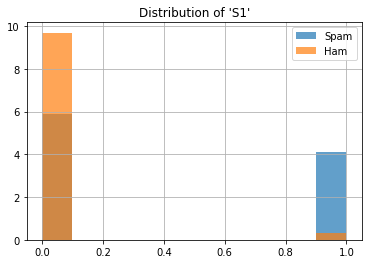

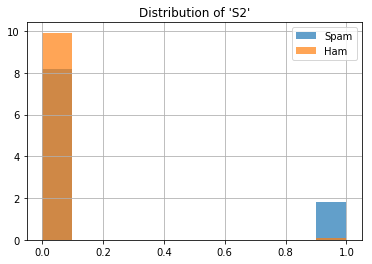

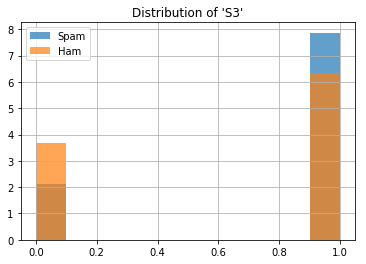

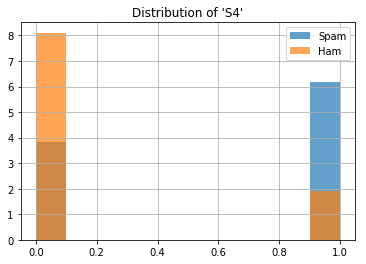

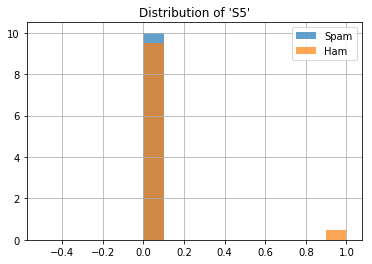

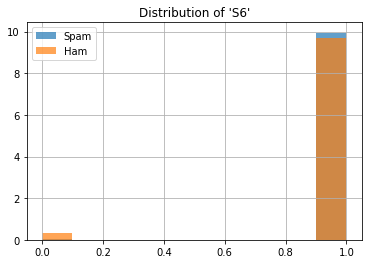

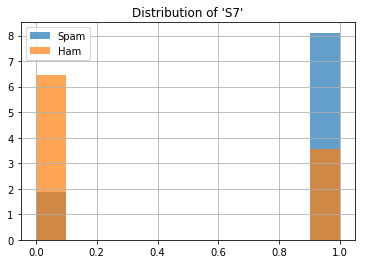

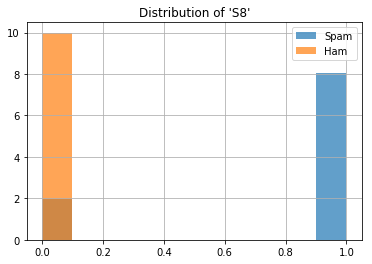

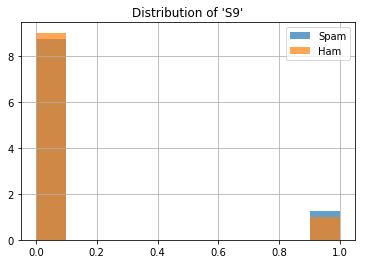

In [26]:
for k in range(9):
    df[df.label == 'spam']["S"+str(k+1)].hist(alpha = 0.7, density = True, label = 'Spam')
    df[df.label == 'ham']["S"+str(k+1)].hist(alpha = 0.7, density = True, label = 'Ham')
    plt.legend()
    plt.title("Distribution of '" + "S"+str(k+1) + "'")
    plt.show()
#Result: seems indeed like very discriminants features, for most

### Train/Test split

In [27]:
features_cols = [k for k in string.punctuation]
features_cols.append("SMS")
features_cols.append("cleaned_SMS")
features_cols.append("word_count")
features_cols.append("S1"), features_cols.append("S2"), features_cols.append("S3"), features_cols.append("S4")
features_cols.append("S5"), features_cols.append("S6"), features_cols.append("S7"), features_cols.append("S8")
features_cols.append("S9")

X_train, X_test, y_train, y_test = train_test_split(df[features_cols], df["target"], test_size = 0.2, random_state = 10, )
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457, 44)
(1115, 44)
(4457,)
(1115,)


### Vectorization

#### Word Tokenazation

In [28]:
vect_SMS = CountVectorizer()
vect_SMS.fit(X_train.SMS)
X_train_vect_SMS = vect_SMS.transform(X_train.SMS)
X_test_vect_SMS = vect_SMS.transform(X_test.SMS)
print(X_train_vect_SMS.shape)
print(X_test_vect_SMS.shape)

(4457, 7757)
(1115, 7757)


In [29]:
vect_cleaned_SMS = CountVectorizer()
vect_cleaned_SMS.fit(X_train.cleaned_SMS)
X_train_vect_cleaned_SMS = vect_cleaned_SMS.transform(X_train.cleaned_SMS)
X_test_vect_cleaned_SMS = vect_cleaned_SMS.transform(X_test.cleaned_SMS)
print(X_train_vect_cleaned_SMS.shape)
print(X_test_vect_cleaned_SMS.shape)

(4457, 8429)
(1115, 8429)


#### Additional Features

In [30]:
additional_features_col_names = ["S"+str(k+1) for k in range(9)]
additional_features_col_names.append("word_count")
ADDITIONAL_FEATURES_COL_NAMES= additional_features_col_names
print(ADDITIONAL_FEATURES_COL_NAMES)

['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'word_count']


In [31]:
X_train_SMS_tokens = pd.DataFrame(X_train_vect_SMS.toarray(), index= X_train.index)
addition_feat_train = X_train[additional_features_col_names]
X_train_SMS_all_feat = pd.concat([X_train_SMS_tokens, addition_feat_train],
                                 axis=1)

X_test_SMS_tokens = pd.DataFrame(X_test_vect_SMS.toarray(), index= X_test.index)
addition_feat_test = X_test[additional_features_col_names]
X_test_SMS_all_feat = pd.concat([X_test_SMS_tokens, addition_feat_test],
                                 axis=1)

print(X_train_SMS_all_feat.shape)
print(X_test_SMS_all_feat.shape)

(4457, 7767)
(1115, 7767)


In [32]:
X_train_cleaned_SMS_tokens = pd.DataFrame(X_train_vect_cleaned_SMS.toarray(), index= X_train.index)
addition_feat_train = X_train[additional_features_col_names]
X_train_cleaned_SMS_all_feat = pd.concat([X_train_cleaned_SMS_tokens, addition_feat_train],
                                         axis=1)

X_test_cleaned_SMS_tokens = pd.DataFrame(X_test_vect_cleaned_SMS.toarray(), index= X_test.index)
addition_feat_test = X_test[additional_features_col_names]
X_test_cleaned_SMS_all_feat = pd.concat([X_test_cleaned_SMS_tokens, addition_feat_test],
                                        axis=1)

print(X_train_cleaned_SMS_all_feat.shape)
print(X_test_cleaned_SMS_all_feat.shape)

(4457, 8439)
(1115, 8439)


We now have our inputs for our models

## Modelling

I'm gonna go from simplest to more complex settings<br/><br/>
I will also try with those inputs :
    1. Original SMS
    2. Cleaned SMS
    3. Original SMS + additional features
    4. Cleaned SMS + additional features

In [33]:
inputs_dict = {"Original_SMS": [X_train_vect_SMS.toarray(), y_train, X_test_vect_SMS.toarray(), y_test],
               "Cleaned_SMS": [X_train_vect_cleaned_SMS.toarray(), y_train, X_test_vect_cleaned_SMS.toarray(), y_test],
               "Original_SMS_and_add_feat": [X_train_SMS_all_feat, y_train, X_test_SMS_all_feat, y_test],
               "Cleaned_SMS_and_add_feat": [X_train_cleaned_SMS_all_feat, y_train, X_test_cleaned_SMS_all_feat, y_test]
              }

### Base Models

In [35]:
def train_and_conf(inputs, model_n_name, display_conf = True , return_scores = False):
    
    model_from_sk, name = model_n_name
    X_train, y_train, X_test, y_test = inputs
    model = model_from_sk
    model.fit(X_train,y_train)

    predictions[name] = model.predict(X_test)
    
    confusion_matrix_model = pd.DataFrame(
        confusion_matrix(y_test, predictions[name]),
        columns=["Predicted Ham", "Predicted Spam"],
        index=["Actual Ham", "Actual Spam"])
    if display_conf == True:    
        display(confusion_matrix_model)
    
    if return_scores == True:    
        return [confusion_matrix_model["Predicted Ham"]["Actual Spam"], confusion_matrix_model["Predicted Spam"]["Actual Ham"]]

In [36]:
#Validation function
n_folds = 3

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
score_tp= make_scorer(tp)
score_tn= make_scorer(tn)
score_fp= make_scorer(fp)
score_fn= make_scorer(fn)

scoring = {'tp' : score_tp, 'tn' : score_tn,
           'fp' : score_fp, 'fn' : score_fn}

def conf_mat_score_cv(model, inputs = [X_train_vect_SMS.toarray(), y_train, X_test_vect_SMS.toarray(), y_test], display_confusion = False, scoring = score_fn):
    
    X_train, y_train, X_test, y_test = inputs
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    scores_cv= cross_val_score(model, X_train, y_train, scoring=scoring, cv = kf)
    
    model.fit(X_train, y_train)
    if display_confusion == True:
        confusion_matrix_model = pd.DataFrame(
            confusion_matrix(y_test, model.predict(X_test)),
            columns=["Predicted Ham", "Predicted Spam"],
            index=["Actual Ham", "Actual Spam"])
        display(confusion_matrix_model)
        
    
    return(scores_cv)

#### Logistic Regression

In [35]:
LogisticRegr = LogisticRegression()
LogisticRegr_cleaned = LogisticRegression()
conf_mat_score_cv(LogisticRegr, inputs = inputs_dict["Original_SMS"], display_confusion = True)
conf_mat_score_cv(LogisticRegr_cleaned, inputs = inputs_dict["Cleaned_SMS"], display_confusion = True)
print("Original SMS Accuracy : " + str(accuracy_score(y_test, LogisticRegr.predict(X_test_vect_SMS))))
print("Cleaned SMS Accuracy : " + str(accuracy_score(y_test, LogisticRegr_cleaned.predict(X_test_vect_cleaned_SMS))))
print("Diff : " + str(100*abs
                      (accuracy_score(y_test, LogisticRegr.predict(X_test_vect_SMS))
                       - accuracy_score(y_test, LogisticRegr_cleaned.predict(X_test_vect_cleaned_SMS)))
                     ))

# already good results without tuning anything, or even using punctuations
# clean Vs unclean didn't make much a difference, good to know for production

,Predicted Ham,Predicted Spam
Actual Ham,962,3
Actual Spam,19,131


,Predicted Ham,Predicted Spam
Actual Ham,962,3
Actual Spam,19,131


Original SMS Accuracy : 0.9802690582959641
Cleaned SMS Accuracy : 0.9802690582959641
Diff : 0.0


I believe that in production, the Actual Spam that we predicted as Ham are our biggest problem<br/>
The actual Ham predicted as Spam are less problematic I would say<br/>
So even though we have a 97% accuracy, this result of 19 Actual Spam predicted as Ham is still quite big since it represents more than 15% of our spams, this is not a really satisfying result.<br/><br/>
A good result would be the other way around<br/>
Those results are not normalized.

In [36]:
for i in inputs_dict:
    print(i + ":")
    LogisticRegr = LogisticRegression()
    score = conf_mat_score_cv(LogisticRegr, inputs = inputs_dict[i], display_confusion = False)
    print("False Negative CV score: " + str(score.mean()) +" (" +str(score.std())+")\n")    

Original_SMS:
False Negative CV score: 25.333333333333332 (5.312459150169742)

Cleaned_SMS:
False Negative CV score: 31.333333333333332 (9.104333522498443)

Original_SMS_and_add_feat:
False Negative CV score: 19.666666666666668 (1.8856180831641267)

Cleaned_SMS_and_add_feat:
False Negative CV score: 21.333333333333332 (1.247219128924647)



#### SVM

In [39]:
for i in inputs_dict:
    print(i + ":")
    model_svm_SVC = svm.SVC(kernel='sigmoid', gamma =  0.01)
    score = conf_mat_score_cv(model_svm_SVC, inputs = inputs_dict[i], display_confusion = True)
    print("False Negative CV score: " + str(score.mean()) +" (" +str(score.std())+")\n")  

Original_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,964,1
Actual Spam,34,116


False Negative CV score: 43.0 (6.683312551921141)

Cleaned_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,964,1
Actual Spam,38,112


False Negative CV score: 54.333333333333336 (6.342099196813483)

Original_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,871,94
Actual Spam,147,3


False Negative CV score: 197.66666666666666 (1.247219128924647)

Cleaned_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,870,95
Actual Spam,147,3


False Negative CV score: 197.66666666666666 (1.247219128924647)



#### Random Forrest

In [37]:
for i in inputs_dict:
    print(i + ":")
    model_rdm_frst = RandomForestClassifier()
    score = conf_mat_score_cv(model_rdm_frst, inputs = inputs_dict[i], display_confusion = True)
    print("False Negative CV score: " + str(score.mean()) +" (" +str(score.std())+")\n")  

Original_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,965,0
Actual Spam,37,113


False Negative CV score: 53.0 (8.16496580927726)

Cleaned_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,965,0
Actual Spam,46,104


False Negative CV score: 59.333333333333336 (7.760297817881877)

Original_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,965,0
Actual Spam,17,133


False Negative CV score: 36.666666666666664 (7.408703590297622)

Cleaned_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,965,0
Actual Spam,27,123


False Negative CV score: 45.666666666666664 (7.3181661333667165)



#### Naive Bayes

##### Gaussian

In [37]:
for i in inputs_dict:
    print(i + ":")
    model_GaussianNB = GaussianNB()
    score = conf_mat_score_cv(model_GaussianNB, inputs = inputs_dict[i], display_confusion = False)
    print("False Negative CV score: " + str(score.mean()) +" (" +str(score.std())+")\n")  

Original_SMS:
False Negative CV score: 18.333333333333332 (6.847546194724712)

Cleaned_SMS:
False Negative CV score: 19.0 (5.715476066494082)

Original_SMS_and_add_feat:
False Negative CV score: 17.0 (4.96655480858378)

Cleaned_SMS_and_add_feat:
False Negative CV score: 17.0 (2.943920288775949)



##### Multinomial

In [38]:
for i in inputs_dict:
    print(i + ":")
    model_MultinomialNB = MultinomialNB(alpha=0.05)
    score = conf_mat_score_cv(model_MultinomialNB, inputs = inputs_dict[i], display_confusion = True)
    print("False Negative CV score: " + str(score.mean()) +" (" +str(score.std())+")\n")  

Original_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,959,6
Actual Spam,8,142


False Negative CV score: 10.666666666666666 (2.8674417556808756)

Cleaned_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,958,7
Actual Spam,10,140


False Negative CV score: 10.333333333333334 (4.027681991198191)

Original_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,961,4
Actual Spam,7,143


False Negative CV score: 8.333333333333334 (2.0548046676563256)

Cleaned_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,961,4
Actual Spam,7,143


False Negative CV score: 8.333333333333334 (2.6246692913372702)



#### Gradient Boosting

In [38]:
for i in inputs_dict:
    print(i + ":")
    model_grad_boost = GradientBoostingClassifier()
    score = conf_mat_score_cv(model_grad_boost, inputs = inputs_dict[i], display_confusion = True)
    print("False Negative CV score: " + str(score.mean()) +" (" +str(score.std())+")\n")  

Original_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,958,7
Actual Spam,37,113


False Negative CV score: 40.666666666666664 (6.599663291074444)

Cleaned_SMS:


,Predicted Ham,Predicted Spam
Actual Ham,960,5
Actual Spam,37,113


False Negative CV score: 53.333333333333336 (10.402991022884823)

Original_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,965,0
Actual Spam,18,132


False Negative CV score: 26.666666666666668 (3.299831645537222)

Cleaned_SMS_and_add_feat:


,Predicted Ham,Predicted Spam
Actual Ham,964,1
Actual Spam,15,135


False Negative CV score: 30.0 (4.320493798938574)



### Deep Learning

#### Straighforward approach

In [35]:
X_train_cleaned_SMS_all_feat.shape, len(ADDITIONAL_FEATURES_COL_NAMES)

((4457, 8439), 10)

In [36]:
import tensorflow as tf
import tflearn
import numpy as np

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, SeparableConv2D
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, multiply, division
from keras.layers import MaxPooling2D, merge, MaxPooling1D, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import sigmoid, tanh
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, Conv1D
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.callbacks import TensorBoard
from keras.models import Model, model_from_json, load_model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical, plot_model
import keras.backend as K

tf.set_random_seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


In [73]:
def build_model(summa = False):

    model = Sequential()
    
    model.add(Dense(64, input_dim=8439))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    
    if summa == True:
        model.summary()

    encoded_repr = Input(shape=(8439, ))
    validity = model(encoded_repr)
    return Model(encoded_repr, validity)

model = build_model(summa = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 64)                540160    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
__________

In [75]:
with tf.Graph().as_default():
    sess = tf.InteractiveSession()
    tf.set_random_seed(1234)
    with sess.as_default():
        model = build_model(summa = False)
        optimizer = Adam(0.001,  0.00001)
        model = build_model()
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

        model.fit(x = X_train_cleaned_SMS_all_feat, y = y_train, batch_size = 64, epochs = 50,
                  verbose = 0, validation_data=(X_test_cleaned_SMS_all_feat, y_test) )
        d_loss = model.evaluate(x = X_test_cleaned_SMS_all_feat, y = y_test, batch_size = 128, verbose = 0)

        prob_pred = model.predict(X_test_cleaned_SMS_all_feat)
        pred = pd.DataFrame(prob_pred,columns=["proba"]).proba.apply(lambda v : 0 if v < 1/2 else 1)
        confusion_matrix_model = pd.DataFrame(
            confusion_matrix(y_test, pred),
            columns=["Predicted Ham", "Predicted Spam"],
            index=["Actual Ham", "Actual Spam"])
        display(confusion_matrix_model)

,Predicted Ham,Predicted Spam
Actual Ham,963,2
Actual Spam,5,145


Those first results seem very promising, let's look at more complex solutions, involving CNNs

#### Convolutional Nets

I tried finding the best approach to text classification. After looking at this paper : https://arxiv.org/pdf/1702.01923.pdf I decided to implement this referenced paper : http://www.aclweb.org/anthology/P14-1062.<br/>
The reason I did that is because, I have less data than they did, and so a convolutionnal approach might be wiser.<br/>
In addition, most of the SMS are very badly spelled, and this paper shows good results without using pre-trained embedding vectors.

I found an implementation here https://github.com/dennybritz/cnn-text-classification-tf and tweaked around a little to fit my problem. 
After just applying that code to my problem I was getting lesser results than with the above straightforward approach :

In [39]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time
import datetime

from tensorflow.contrib import learn


import cnn_text_classification_tf_master.data_helpers as data_helpers
import cnn_text_classification_tf_master.training_helper
from cnn_text_classification_tf_master.training_helper import create_tf_operations, dev_step, train_step
from cnn_text_classification_tf_master.text_cnn import TextCNN
from cnn_text_classification_tf_master.text_cnn_2 import TextCNN_2

In [40]:
dropout_keep_prob  = 0.5
df['spam'] = df.label.map({'ham':0, 'spam':1})
df['ham'] = df.label.map({'ham':1, 'spam':0})

examples = [s.strip() for s in df.SMS.values]
x_text = [data_helpers.clean_str(sent) for sent in examples]
df["cleaned_SMS_2"] = x_text

max_document_length = max([len(x.split(" ")) for x in x_text])

vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
vocab_processor.fit(df["cleaned_SMS_2"])
df["cleaned_SMS_2_ids"] = df.cleaned_SMS_2.apply(lambda v : list(vocab_processor.transform([v]))[0])
df.head()

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


,cleaned_SMS,label,SMS,target,!,"""",#,$,%,&,...,S4,S5,S6,S7,S8,S9,spam,ham,cleaned_SMS_2,cleaned_SMS_2_ids
0,go until jurong point crazy available only in ...,ham,"Go until jurong point, crazy.. Available only ...",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,"go until jurong point , crazy available only i...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,ok lar joking wif u oni,ham,Ok lar... Joking wif u oni...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,ok lar joking wif u oni,"[21, 22, 23, 24, 25, 26, 0, 0, 0, 0, 0, 0, 0, ..."
2,free entry in 2 a wkly comp to win fa cup fina...,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,0,0,0,0,0,1,...,1,0,1,1,1,0,1,0,free entry in 2 a wkly comp to win fa cup fina...,"[27, 28, 8, 29, 30, 31, 32, 33, 34, 35, 36, 37..."
3,u dun say so early hor u c already then say,ham,U dun say so early hor... U c already then say...,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,u dun say so early hor u c already then say,"[25, 54, 55, 56, 57, 58, 25, 50, 59, 60, 55, 0..."
4,nah i dont think he goes to usf he lives aroun...,ham,"Nah I don't think he goes to usf, he lives aro...",0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,"nah i do n't think he goes to usf , he lives a...","[61, 62, 63, 64, 65, 66, 67, 33, 68, 66, 69, 7..."


In [148]:
X_train_df, X_test_df, y_train, y_test = train_test_split(df[["cleaned_SMS_2_ids","cleaned_SMS_2", "label"]],
                                                          df[["ham", "spam"]].values,
                                                          test_size = 0.15, random_state = 10, )

X_train = np.array(list(X_train_df.cleaned_SMS_2_ids.values))
X_test = np.array(list(X_test_df.cleaned_SMS_2_ids.values))

print(X_train.shape)
print(y_train.shape)

(4736, 190)
(4736, 2)


Just using the text, without any of the addditional features, as a Baseline :

In [149]:
FILTER_SIZES = "3,4,5"
NUM_FILTERS = 16
BATCH_SIZE = 64
NUM_EPOCHS = 100
EMBEDDING_SIZE = 16

with tf.Graph().as_default():
    sess = tf.InteractiveSession()
    tf.set_random_seed(1234)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=max_document_length,
            num_classes=2,
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size= EMBEDDING_SIZE,
            filter_sizes=list(map(int, FILTER_SIZES.split(","))),
            num_filters=NUM_FILTERS,
            l2_reg_lambda=0.0)
        train_op, summaries_ops, summary_writers, checkpoint_prefix, saver, global_step = create_tf_operations(cnn, sess)
        
        
        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(X_train, y_train)), batch_size = BATCH_SIZE, num_epochs = NUM_EPOCHS)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)

            train_step(cnn, x_batch, y_batch, dropout_keep_prob, sess,
                       ops = [train_op, global_step, summaries_ops[0]],
                       train_summary_writer = summary_writers[0])
            
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % 300 == 0:
                dev_step(cnn, X_test, y_test, sess,
                         ops = [global_step, summaries_ops[1]],
                         writer=summary_writers[1])

            if current_step % 300 == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                
feed_dict = {
  cnn.input_x: X_test,
  cnn.input_y: y_test,
  cnn.dropout_keep_prob: 1.0
}
step, summaries, loss, accuracy, pred= sess.run(
    [global_step, summaries_ops[1], cnn.loss, cnn.accuracy, cnn.predictions],
    feed_dict)

y_tstst = y_test[:,1]
confusion_matrix_model = pd.DataFrame(
    confusion_matrix(y_tstst, pred),
    columns=["Predicted Ham", "Predicted Spam"],
    index=["Actual Ham", "Actual Spam"])
display(confusion_matrix_model)

Writing to C:\Users\woill\Documents\Test Technique\Navee\runs\1541183163

Total nb of params  = 142498
Evaluation : step 300, loss 0.315028, acc 0.869617
Evaluation : step 600, loss 0.181138, acc 0.940191
Evaluation : step 900, loss 0.0974325, acc 0.971292
Evaluation : step 1200, loss 0.0683384, acc 0.977273
Evaluation : step 1500, loss 0.0562849, acc 0.983254
Evaluation : step 1800, loss 0.0497262, acc 0.98445
Evaluation : step 2100, loss 0.0447637, acc 0.986842
Evaluation : step 2400, loss 0.0421315, acc 0.985646
Evaluation : step 2700, loss 0.0402927, acc 0.986842
Evaluation : step 3000, loss 0.0394435, acc 0.985646
Evaluation : step 3300, loss 0.0376129, acc 0.988038
Evaluation : step 3600, loss 0.0380172, acc 0.986842
Evaluation : step 3900, loss 0.038865, acc 0.985646
Evaluation : step 4200, loss 0.0387956, acc 0.986842
Evaluation : step 4500, loss 0.0388852, acc 0.985646
Evaluation : step 4800, loss 0.0388064, acc 0.985646
Evaluation : step 5100, loss 0.0405627, acc 0.985646
Eva

,Predicted Ham,Predicted Spam
Actual Ham,716,11
Actual Spam,2,107


The differnece in the data is that this CNN approach isn't taking into account the additional features that we defined above. And as we saw, those additiona features seem to be making a difference.<br/>
So here, I am going to add those features in the following way :
    1. Get my sentence
    2. I embedded it
    3. I apply different convolutionnal and max pooling layers
    4. I concatenate the outputs of step 3. and flatten the vector (so far, no changes)
    5. I concat this flatten vector with a feature vector, that is computed from the additional features I defined above (only difference with the usual model)
    6. I use a dense layer to get my scores from this concatenation, used to define the loss and to train the network (same as before)

In [150]:
print(ADDITIONAL_FEATURES_COL_NAMES)

['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'word_count']


In [151]:
X_train_df, X_test_df, y_train, y_test = train_test_split(df[["cleaned_SMS_2_ids","cleaned_SMS_2", "label",
                                                              'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'word_count']],
                                                          df[["ham", "spam"]].values,
                                                          test_size = 0.15, random_state = 10, )

X_train_txt = np.array(list(X_train_df.cleaned_SMS_2_ids.values))
X_test_txt = np.array(list(X_test_df.cleaned_SMS_2_ids.values))

X_train_add_feat = np.array(X_train_df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'word_count']].values)
X_test_add_feat = np.array(X_test_df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'word_count']].values)

X_train = np.concatenate((X_train_txt, X_train_add_feat), axis = 1)
X_test = np.concatenate((X_test_txt, X_test_add_feat), axis = 1)

print(X_train.shape)
print(y_train.shape)

(4736, 200)
(4736, 2)


In [154]:
from cnn_text_classification_tf_master.text_cnn_2 import TextCNN_2
FILTER_SIZES = "3,4,5"
NUM_FILTERS = 16
BATCH_SIZE = 64
NUM_EPOCHS = 100
EMBEDDING_SIZE = 16
UNITS_ADD_FEAT = 16

with tf.Graph().as_default():
    sess = tf.InteractiveSession()
    tf.set_random_seed(1234)
    with sess.as_default():
        cnn_2 = TextCNN_2(
            sequence_length=max_document_length,
            nb_of_add_feat = int(len(ADDITIONAL_FEATURES_COL_NAMES)),
            num_classes=2,
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size= EMBEDDING_SIZE,
            filter_sizes=list(map(int, FILTER_SIZES.split(","))),
            num_filters=NUM_FILTERS,
            units_add_feat = UNITS_ADD_FEAT,
            l2_reg_lambda=0.0)
        train_op, summaries_ops, summary_writers, checkpoint_prefix, saver, global_step = create_tf_operations(cnn_2, sess)
        
        
        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(X_train, y_train)), batch_size = BATCH_SIZE, num_epochs = NUM_EPOCHS)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)

            train_step(cnn_2, x_batch, y_batch, dropout_keep_prob, sess,
                       ops = [train_op, global_step, summaries_ops[0]],
                       train_summary_writer = summary_writers[0])
            
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % 300 == 0:
                dev_step(cnn_2, X_test, y_test, sess,
                         ops = [global_step, summaries_ops[1]],
                         writer=summary_writers[1])

            if current_step % 300 == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                
feed_dict = {
  cnn_2.input_x: X_test,
  cnn_2.input_y: y_test,
  cnn_2.dropout_keep_prob: 1.0
}
step, summaries, loss, accuracy, pred= sess.run(
    [global_step, summaries_ops[1], cnn_2.loss, cnn_2.accuracy, cnn_2.predictions],
    feed_dict)

y_tstst = y_test[:,1]
confusion_matrix_model = pd.DataFrame(
    confusion_matrix(y_tstst, pred),
    columns=["Predicted Ham", "Predicted Spam"],
    index=["Actual Ham", "Actual Spam"])
display(confusion_matrix_model)

Writing to C:\Users\woill\Documents\Test Technique\Navee\runs\1541183466

Total nb of params  = 142706
Evaluation : step 300, loss 0.3014, acc 0.869617
Evaluation : step 600, loss 0.156409, acc 0.947368
Evaluation : step 900, loss 0.0925513, acc 0.967703
Evaluation : step 1200, loss 0.0673488, acc 0.980861
Evaluation : step 1500, loss 0.053958, acc 0.986842
Evaluation : step 1800, loss 0.0473267, acc 0.988038
Evaluation : step 2100, loss 0.0447995, acc 0.989234
Evaluation : step 2400, loss 0.0414151, acc 0.989234
Evaluation : step 2700, loss 0.0417245, acc 0.989234
Evaluation : step 3000, loss 0.0395906, acc 0.990431
Evaluation : step 3300, loss 0.0391964, acc 0.990431
Evaluation : step 3600, loss 0.0397673, acc 0.990431
Evaluation : step 3900, loss 0.0409405, acc 0.990431
Evaluation : step 4200, loss 0.0405389, acc 0.990431
Evaluation : step 4500, loss 0.0433098, acc 0.990431
Evaluation : step 4800, loss 0.0433498, acc 0.991627
Evaluation : step 5100, loss 0.0467918, acc 0.990431
Eval

,Predicted Ham,Predicted Spam
Actual Ham,720,7
Actual Spam,2,107


## Conclusion

After having tried a few "classical" models and some a little more deep the conclusion is that overall, the perfomrance of Naive Bayes Multinomial is the best one amongst the base models. <br/><br/>
One thing to keep in mind is the following result : the more I made my networks deeper and wider, the lesser the results. This is due to the data, there is not enough data to correctly train a very deep NN.<br/>In our case, more than 400k parameters is too much in the case of CNN<br/><br/>
In the end, the best result comes from the very last model, where I implemented the classical CNN for text classification and added 10 choosen features